## Compter et distribuer dans le temps: les années de naissance de la population

Version simplifiée du carnet sans accès à la base de données

* Ce carnet indique des pistes pour compter et représenter une distribution de naissances dans le temps.
* Il donne également des exemples de la manière différente de travailler avec les librairies vega-lite, altair et plotly
* Son exécution présuppose l'utilisation d'un environnement _conda_ dans lequel les librairies suivantes sont installées 

In [51]:
import sqlite3 as sql
import csv
import altair as alt
import json
import plotly.express as px
from collections import Counter
from IPython.display import SVG
import pprint

## Accès aux données à afficher

* Exécuter la requête suivante sur le [point d'accès SPARQL de DBPedia](https://dbpedia.org/sparql):

```SQL
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX dbr: <http://dbpedia.org/resource/>
PREFIX dbo: <http://dbpedia.org/ontology/>
PREFIX dbp: <http://dbpedia.org/property/>
SELECT ?o1 ?birthYear
WHERE {
  SELECT DISTINCT ?s ?birthYear
  WHERE { 

    }
    ?s ?p dbr:Poet;
      dbo:birthDate ?birthDate;
  rdfs:label ?label.

  ORDER BY ?birthDate
  }  
  ```
* Dans le menu __Results Format__ de l'interface de requêtes DBPedia choisir l'entrée __CSV__ (texte séparé par virgule)
* Télécharger le fichier CSV vers le __dossier data__ du présent dépôt en l'enregistrant sous le nom:
    * poets_birthdate.csv

<br/>

### Accès aux données du fichier stocké


In [52]:
### Définir le chemin du fichier
csv_file = 'data/poets_birthdate.csv'

In [53]:
### Ouvrir le fichier CSV et mettre son contenu 
# dans la variable de type liste : csv_content initialisée préalablement
csv_content = []
with open(csv_file) as f: 
    rdr = csv.reader(f, delimiter=',')
    for r in rdr:
        csv_content.append(r)
csv_content[:3]

[['s', 'birthDate'],
 ['http://dbpedia.org/resource/Raul_Bopp', '0004-08-04'],
 ['http://dbpedia.org/resource/Lucan', '0039-11-03']]

In [54]:
### Préparer l'extractions de noms à partir des URI
csv_content[1][0].replace('http://dbpedia.org/resource/','')

'Raul_Bopp'

In [55]:
### Extraire l'année de la date si nécessaire 
# et convertir en entier avec cette méthode
# 
dt = '0004-08-04'
a = int(dt[:4]) ; a

4

In [56]:
### Préparer et mettre en forme les données
r = []
for i in csv_content[1:]:
    ### extraire les noms à partir des URI
    a = i[0].replace('http://dbpedia.org/resource/','')
    ### remplacer les tirets sous la liste par des espaces
    b = a.replace('_',' ')
    ### extraire l'année si date complète — décommenter si nécessaire
    c = int(i[1][:4])
    #c = int(i[1])
    r.append([i[0], b, c ])

In [57]:
### Inspecter les trois première lignes du résultat
r[:4]

[['http://dbpedia.org/resource/Raul_Bopp', 'Raul Bopp', 4],
 ['http://dbpedia.org/resource/Lucan', 'Lucan', 39],
 ['http://dbpedia.org/resource/Paulinus_of_Nola', 'Paulinus of Nola', 354],
 ['http://dbpedia.org/resource/Columba', 'Columba', 521]]

In [58]:
len(csv_content)

5560

In [59]:
### Extraire les années pour avoir une liste des années pour tous les individus
# Méthode de la list comprehension
la = [e[2] for e in r]; la[:5]

[4, 39, 354, 521, 726]

In [60]:
### Compter le nombre d'occurrences pour chaque année
ctr = Counter(la)
ctr_l = list(ctr.items())
ctr_l[:7]

[(4, 1), (39, 1), (354, 1), (521, 1), (726, 1), (1002, 1), (1007, 1)]

### Ecriture des données dans un fichier et affichage avec Vega Lite

In [61]:
### Créer un dictionnaire
data = [{'year': e[0], 'eff': e[1]} for e in ctr_l]

In [62]:
with open('data/birth_years_grouped.json', 'w') as f:
    json.dump(data, f)

In [63]:
### Afficher les effectifs par année avec un diagramme à barres

# Ce graphique utilise la librairie vega-lite, disponible dans la librairie altair
# Tous les paramètres sont indiqués explicitement
# NB : noter le problème des années qui MANQUENT dans l'axe du temps !
# Toutes les années doivent être représentées dans l'axe du temps!

alt.Chart(dt).from_dict({
    "data": {
    # "url" : "http://localhost:8888/files/astronomers/notebooks_jupyter/dbpedia_exploration/data/birth_years_grouped.json"
    "values": data
    },
    "mark": "bar", 
    "width": 1000,
    "height": 400,
    "encoding": {
        # Remplacer type de x par  : 'quantitative' et observer la différence
        "x": {"field": "year", "type": "ordinal", 
              ## décommenter et observer
              # "axis": {"values": [1450, 1500, 1550, 1600, 1650, 1700 ,1750, 1800]}
             }, 
         "y": {"field": "eff", "type": "quantitative"},
        

    }
}

)

alt.Chart(...)

### Créer la liste de toutes les années et recoder les données

In [64]:
### Inspecter les années du jeux de données
# et cherche l'année minimale et maximale
ys = [y[2] for y in r]; print (ys[:3], ys[-3:])
min(ys), max(ys)

[4, 39, 354] [-70, -65, -43]


(-70, 2002)

In [65]:
### Créer une liste d'années complète
y_l = list(range(min(ys), max(ys) + 1, 1))
print(len(y_l))
### Afficher le début et la fin de la série complète
y_l[:4],y_l[-4:]

2073


([-70, -69, -68, -67], [1999, 2000, 2001, 2002])

In [66]:
### Recoder les données
# Première boucle for: pour chaque année de la liste années, effectuer...
# Deuxième boucle for: pour chaque entrée de la liste des valeurs, effectuer...
y_r = []
for a in y_l:
    effectif = 0
    noms =  []
    for v in r:
        if a == v[2]:
            effectif += 1
            noms.append(v[1])
            pass
    y_r.append([a, effectif, ', '.join(noms)])  
    
pprint.pprint(y_r[:5])

[[-70, 1, 'Virgil'], [-69, 0, ''], [-68, 0, ''], [-67, 0, ''], [-66, 0, '']]


In [67]:
### Mise en forme
[f'Année: {e[0]}, effectif: {e[1]}, personnes: {e[2]}.' if len(e[2]) > 0  
 else f'Année: {e[0]}, effectif: {e[1]}.' for e in y_r][:5]

['Année: -70, effectif: 1, personnes: Virgil.',
 'Année: -69, effectif: 0.',
 'Année: -68, effectif: 0.',
 'Année: -67, effectif: 0.',
 'Année: -66, effectif: 0.']

In [68]:
### Créer un dictionnaire contenant ces mêmes années
data = [{'year': e[0], 'eff': e[1], 'names': e[2]} for e in y_r]

In [69]:
### Ecrire le dictionnaire dans un fichier de son projet au format JSON
with open('data/birth_years_grouped_y.json', 'w') as f:
    json.dump(data, f)

In [70]:
### Représenter les valeurs correctement, y compris les années sans naissance
# Si on effleure les barres on découvre les noms des personnes nées en telle année
alt.Chart.from_dict({
    "data": {
    ### Choisir si on veut afficher les données de la variable 'data'
    # ou lire le fichier qui se trouve sur le serveur local jupyter (localhost:8888/files)
    "values" : data    
    # "url" : "http://localhost:8888/files/astronomers/notebooks_jupyter/dbpedia_exploration/data/birth_years_grouped_y.json"
    },
    "mark": "bar",
    # {
    #     "type":"bar",
    #     "tooltip": {"content": "data"}
    # }, 
    "encoding": {
        "x": {"field": "year", "type": "ordinal", 
              "axis": {"values": [1450, 1500, 1550, 1600, 1650, 1700 ,1750, 1800]}}, # ordinal, quantitative
         "y": {"field": "eff", "type": "quantitative"},
        "tooltip": [
      {"field": "year", "type": "quantitative", "title": "Year"},
     {"field": "names", "type": "nominal", "title": "Names"}
    ]
    },
    "width": 1000, 
    "height": 300
}

)

alt.Chart(...)

### Exporter les images

In [71]:
### enregistrer au format HTML et ouvrir comme page web
fig.write_html("pictures/birth_years_grouped.html")

In [72]:
### enregistrer au format SVG
# remplacer suffixe: .svg,  .html, .jpg ...
fig.write_image("pictures/birth_years_grouped.svg") 

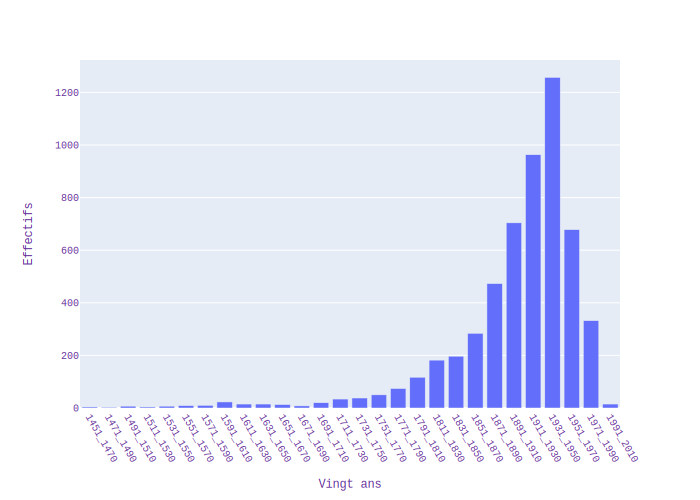

In [73]:
chemin = "pictures/birth_years_grouped.svg"
SVG(filename=chemin)

### Regrouper par périodes de vingt ans

L'objectif est d'améliorer la lisibilité de l'évolution de la distribution des naissances dans le temps

In [74]:
min(y_l), max(y_l)

(-70, 2002)

In [75]:
### Créer des périodes 
periode = 20 # remplacer si souhaité avec 10, 15, 30 etc.
per_l = list(range(1451, 2000, periode))
per_ll = [(l, l+ periode -1) for l in per_l]
len(per_ll),per_ll[:3],per_ll[-3:]

(28,
 [(1451, 1470), (1471, 1490), (1491, 1510)],
 [(1951, 1970), (1971, 1990), (1991, 2010)])

#### Exemple de période

* Qui nait dans la même 'génération' dépend du découpage des générations
* Si on fait glisser les périodes le découpage ne sera pas le même

'1551_1570',
  12: 
  'Simon_Forman',
   ' Jost_Bürgi',
   ' Petrus_Ryff',
   'Francis_Bacon',
   ' Christopher_Heydon',
   ' Henry_Briggs_(mathematician)',
   'Christen_Sørensen_Longomontanus',
   'Galileo_Galilei',
   ' Cort_Aslakssøn',
   'Laurentius_Paulinus_Gothus',
   'Tommaso_Campanella',
   ' Marino_Ghetaldi'

In [76]:
### Recoder les données par période
# Première boucle for: pour chaque période de la liste périodes, effectuer...
# Deuxième boucle for: pour chaque entrée de la liste des valeurs, effectuer...

per_r = []
for a in per_ll:
    # créer le label de la période 
    label = f'{a[0]}_{a[1]}'
    # réinitialiser ces variables à chaque boucle
    effectif = 0
    noms =  []
    for v in r:
        if v[2] >= a[0] and v[2] <= a[1]:
            effectif += 1
            noms.append(v[1])
            # pass
    per_r.append([label, effectif, noms])

per_r[-3:]        

[['1951_1970',
  678,
  ['Ali Arshad Mir',
   'Ashfaq Hussain',
   'Timothy Murphy (poet)',
   'Pritish Nandy',
   'Bibhu Padhi',
   'Neil Shepard',
   "Z'EV",
   'Prasanna (theatre director)',
   'Jure Detela',
   'Meena Alexander',
   'Leevi Lehto',
   'Craig Czury',
   'Susan Musgrave',
   'Rais Ansari',
   'Bhimrao Panchale',
   'Lillian Allen',
   'Pavel Zajíček',
   'Jamal Ehsani',
   'Joy Harjo',
   'Peter Carravetta',
   'Salvatore Toma',
   'Paul Zarzyski',
   'Peter Balakian',
   'Rosario Murillo',
   'Robert Priest',
   'Angela Jackson',
   'Iztok Osojnik',
   'Ana Miranda',
   'Salim Barakat',
   'Alamgir Hashmi',
   'Andrés Caicedo',
   'Bakhytzhan Kanapyanov',
   'Mirta Rosenberg',
   'Brother Shortman',
   'Kiwao Nomura',
   'Gary McCormick',
   'Ioan Baba',
   'Bruno K. Öijer',
   'Rønnaug Kleiva',
   'Torild Wardenær',
   'William Sewell (poet)',
   'Uday Prakash',
   'Jimmy Santiago Baca',
   'Dorianne Laux',
   'Barry Dempster',
   'Richard Vetere',
   'Robert Rocco 

In [77]:
### Représentation graphique: graphique à barres
# https://plotly.com/python/bar-charts/

a_x = [i[0] for i in per_r]
a_y = [i[1] for i in per_r]
labels = [[m.strip() for m in i[2]] for i in per_r]


    
fig = px.bar(x=a_x, y=a_y, labels={'x':'Vingt ans','y':'Effectifs'}
        # hover_name=hover
         )


# Changer l'angle des x-labels
fig.update_xaxes(tickangle=60, )


fig.update_traces(
    customdata = labels,
    # textposition="top center",
    hovertemplate="<br>".join([
        "%{y} personnes:",
        "%{customdata}",
    ]))

fig.update_layout(hovermode="x unified",
        font=dict(
                family="Courier New, monospace",
                size=10,  # Set the font size here
                color="RebeccaPurple"
        )
                 )
    
# Noter les fonctionnalités permettant d'interagir avec le graphique
fig.show()

In [78]:
### enregistrer au format HTML
fig.write_html("pictures/birth_years_period.html") 

In [79]:
### enregistrer au format SVG
# remplacer suffixe: .svg, .jpg, .png
fig.write_image("pictures/birth_years_period.png") 

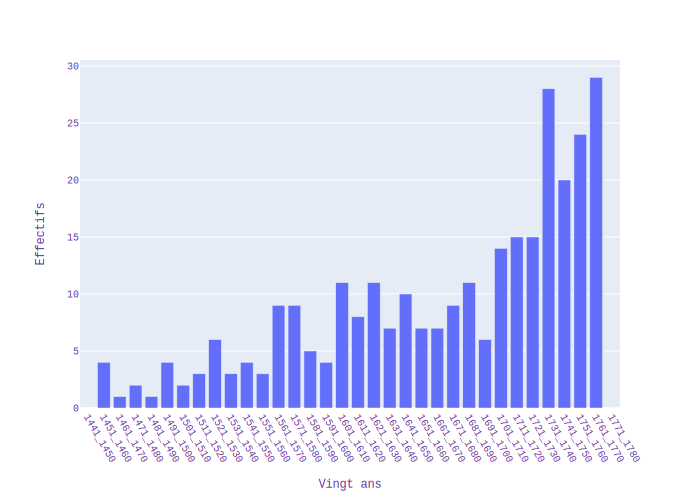

In [80]:
chemin = "pictures/birth_years_period.svg"
SVG(filename=chemin)

### Le même graphique avec Vega-Lite Altair

In [81]:
data = [{'per': e[0], 'eff': e[1], 'names': '\n'.join(e[2])} for e in per_r]

In [82]:
with open('data/birth_years_grouped_per.json', 'w') as f:
    json.dump(data, f)

In [83]:
alt.Chart.from_dict({
    "data": {
    "values" : data    
    # "url" : "http://localhost:8888/files/astronomers/notebooks_jupyter/dbpedia_exploration/data/birth_years_grouped_per.json"
    },
    "mark": "bar",
    # {
    #     "type":"bar",
    #     "tooltip": {"content": "data"}
    # }, 
    "encoding": {
        "x": {"field": "per", "type": "ordinal", "title": "Period" 
             }, 
         "y": {"field": "eff", "type": "quantitative", "title": "Effectif"},
        "tooltip": [
      {"field": "eff", "type": "nominal", "title": "Effectif"},
     {"field": "names", "type": "nominal", "title": "Names"},
    ]
    },
  "config": {

    "axisX": {
      "labelAngle": 60
    }
  },
    "width": 1000, 
    "height": 500
}
)

alt.Chart(...)

In [84]:
data = [{'per': e[0], 'eff': e[1], 'names': '\n'.join(e[2])} for e in per_r]

In [85]:
### Ajouter une moyenne glissante
# Documentation:
#     https://joelostblom.github.io/altair-docs/gallery/bar_with_rolling_mean.html

## https://altair-viz.github.io/user_guide/data.html
data_trsf = alt.Data(values=data)

bar = alt.Chart(data_trsf).mark_bar().encode(
    x='per:N',
    y='eff:Q',
    tooltip=('eff:Q', 'names:N')
   
)

line = alt.Chart(data_trsf).mark_line(color='red').transform_window(
    # The field to average
    rolling_mean='mean(eff)',
    # The number of values before and after the current value to include.
    frame=[-9, 0]
).encode(
    x='per:O',
    y='rolling_mean:Q'
)

(bar + line).properties(height= 600, width=1000,  title = 'Distribution des naissances par périodes de vingt ans')

alt.LayerChart(...)

In [86]:
### Ajouter une moyenne glissante
# Documentation:
#     https://joelostblom.github.io/altair-docs/gallery/bar_with_rolling_mean.html

## https://altair-viz.github.io/user_guide/data.html
data_trsf = alt.Data(values=data)

bar = alt.Chart(data_trsf).mark_bar().encode(
    x='per:N',
    y='eff:Q',
    tooltip=('eff:Q', 'names:N')
   
)

line = alt.Chart(data_trsf).mark_line(color='red').transform_window(
    # The field to average
    rolling_mean='mean(eff)',
    # The number of values before and after the current value to include.
    frame=[-1, 1]
).encode(
    x='per:O',
    y='rolling_mean:Q'
)

(bar + line).properties(height= 600, width=1000,  title = 'Distribution des naissances par périodes de vingt ans')

alt.LayerChart(...)

In [87]:
### Sauvegarder l'image en HTML pour l'afficher ensuite sur un site web
chemin = "pictures/altair_birth_years_period.html"
(bar+line).properties(height= 600, width=1000).save(chemin)